## CFAR: 恒虚警检测(Constant False-Alarm Rate)

![](images/2025-03-16-17-07-52.png)

### 参考资料

- [雷达信号处理中的恒虚警检测(CFAR)技术概述](https://blog.csdn.net/xhblair/article/details/138784323)

- [雷达信号处理之恒虚警（CFAR）检测基础知识总结](https://zhuanlan.zhihu.com/p/652220176)

### 目标SNR、虚警率、检出率之间的关系

In [ ]:
# ! pip install marcumq 

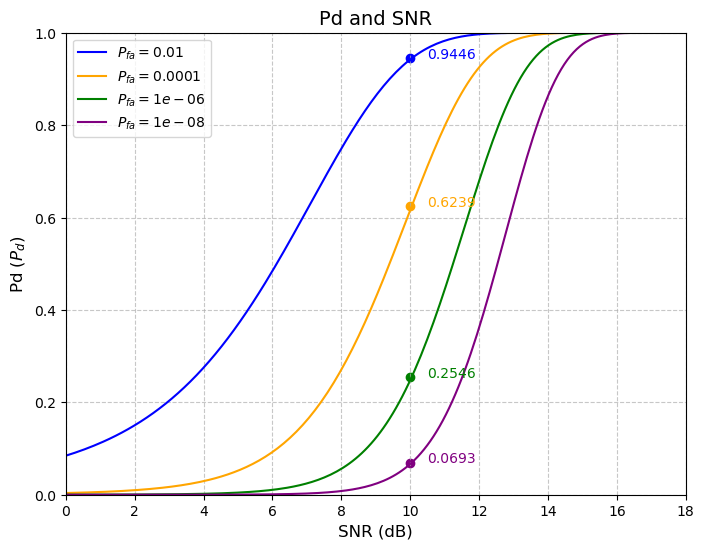

In [47]:
import numpy as np  
import matplotlib.pyplot as plt  
import marcumq  

# -----------------------  
# 参数设置  
# -----------------------  
P_fa_values = [1e-2, 1e-4, 1e-6, 1e-8]  # 虚警概率  
SNR_dB = np.linspace(0, 18, 200)         # 信噪比(dB)  
SNR = 10 ** (SNR_dB / 10)                # 线性信噪比  

# -----------------------  
# 检测概率计算  
# -----------------------  
Pd_curves = []  
for P_fa in P_fa_values:  
    threshold = np.sqrt(-2 * np.log(P_fa))  # 根据 P_fa 计算门限  
    Pd = marcumq.marcumq(1, np.sqrt(2 * SNR), threshold)  # 检测概率公式  
    Pd_curves.append(Pd)  

# -----------------------  
# 标注 SNR = 10dB 点  
# -----------------------  
SNR_dB_target = 10  
SNR_target_idx = np.argmin(np.abs(SNR_dB - SNR_dB_target))  # 找到最接近10dB的索引  
annotations = []  # 存储每条曲线的标注信息  
for i, P_fa in enumerate(P_fa_values):  
    Pd_value = Pd_curves[i][SNR_target_idx]  # 对应虚警概率的检测概率  
    annotations.append((SNR_dB_target, Pd_value, f'$P_{{fa}} = {P_fa:.0e}, P_d = {Pd_value:.4f}$'))  


# -----------------------  
# 绘制 Pd-SNR 曲线  
# -----------------------  
plt.figure(figsize=(8, 6))  
colors = ['b', 'orange', 'g', 'purple']  

for i, P_fa in enumerate(P_fa_values):  
    plt.plot(SNR_dB, Pd_curves[i], label=f'$P_{{fa}} = {P_fa}$', color=colors[i])  
    # 标注 SNR = 10dB 的点  
    SNR_dB_target, Pd_value, text = annotations[i]  
    plt.scatter(SNR_dB_target, Pd_value, color=colors[i], label=None)  
    plt.text(SNR_dB_target + 0.5, Pd_value, f'{Pd_value:.4f}', color=colors[i], fontsize=10)  


plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlabel('SNR (dB)', fontsize=12)  
plt.ylabel('Pd ($P_d$)', fontsize=12)  
plt.title('Pd and SNR', fontsize=14)  
plt.legend(fontsize=10)  
plt.xlim([0, 18])  
plt.ylim([0, 1])  
plt.show()  

从上面的仿真结果中可以得到的一些结论：

1、虚警率不变时，检出率会随着目标SNR的增加而增加的，这呼应了我们之前对检出率的定义，虚警率不变说明阈值不变，SNR增加表示曲线整体右移，于是检出率(阴影部分面积)自然增加。

2、如果我们使目标SNR不变，去看检出率与虚警率的变化关系(对应图中固定横坐标)：检出率会随着虚警率的增加而增加：虚警率变大说明阈值变小了，阈值变小了自然检出率会增加，所以我们要想提高检出率，要么想办法提高目标的SNR，而如果在目标SNR没法提高时我们只能牺牲虚警率。

3、接上面第2点，这条曲线只是告诉我们特定Pfa下目标SNR与检出率的关系，我们可以通过设计不同的Pfa来使得这条曲线上下移动，也即：由Pfa的变化导致的阈值的变化只是会影响同一个SNR下的检测概率发生变化，不是说设定某个阈值后阈值以下的SNR的目标就检测不出来了！

---

## 均值类CFAR门限因子

### CA-CFAR

对于 **CA-CFAR（Cell-Averaging CFAR）**，门限因子 $ T $的确定通常基于设定的虚警概率 $ P_{fa} $ 和参考单元数目 $ R $。其计算公式为：

$$
T = \left( P_{fa} \right)^{-1/R} - 1
$$

### 公式含义
- $ P_{fa} $：虚警概率（False Alarm Probability），表示没有目标的情况下信号超过门限的概率。
- $ R $：参考单元的数量（通常为窗口数据的个数）。
- $ T $：门限因子，用于调整检测门限的大小。

### 具体计算步骤
1. **给定参数：**
   - 确定虚警概率 $ P_{fa} $，例如 $ P_{fa} = 10^{-6} $
   - 确定参考单元数 $ R $（例如，若滑窗左右各有 12 个参考单元，则 $R = 24 $。
   
2. **带入公式计算：**
   $$ 
   T = \left( P_{fa} \right)^{-1/R} - 1
   $$

   例如：
   - $ P_{fa} = 10^{-6} $
   - $  R = 24 $ 
   
   则：
   $$
   T = \left( 10^{-6} \right)^{-1/24} - 1 = 0.316
   $$

### 实现代码示例（Python）
以下是用 Python 计算 CA-CFAR 中门限因子的简单代码实现：

```python
import numpy as np

# 参数设置
P_fa = 1e-6  # 虚警概率
R = 24       # 参考单元数目

# 计算门限因子 T
T = (P_fa ** (-1 / R)) - 1
print(f"CA-CFAR 的门限因子 T = {T:.4f}")
```

### 总结
门限因子 $ T $直接由虚警概率 $ P_{fa} $ 和参考单元数 $ R $确定，公式简单且易计算。这是 CA-CFAR 方法的一大特点，使其实现较为方便。

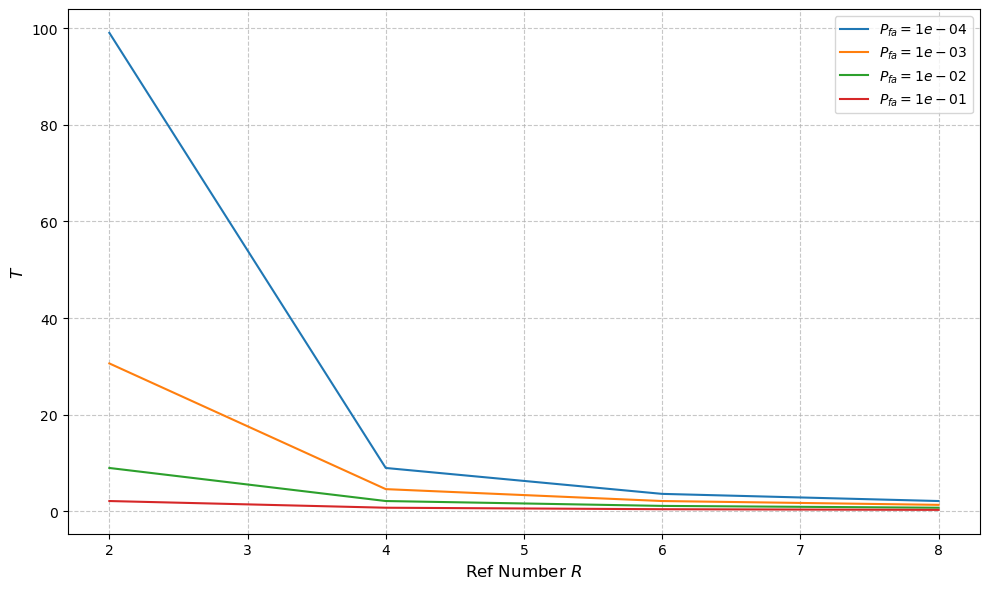

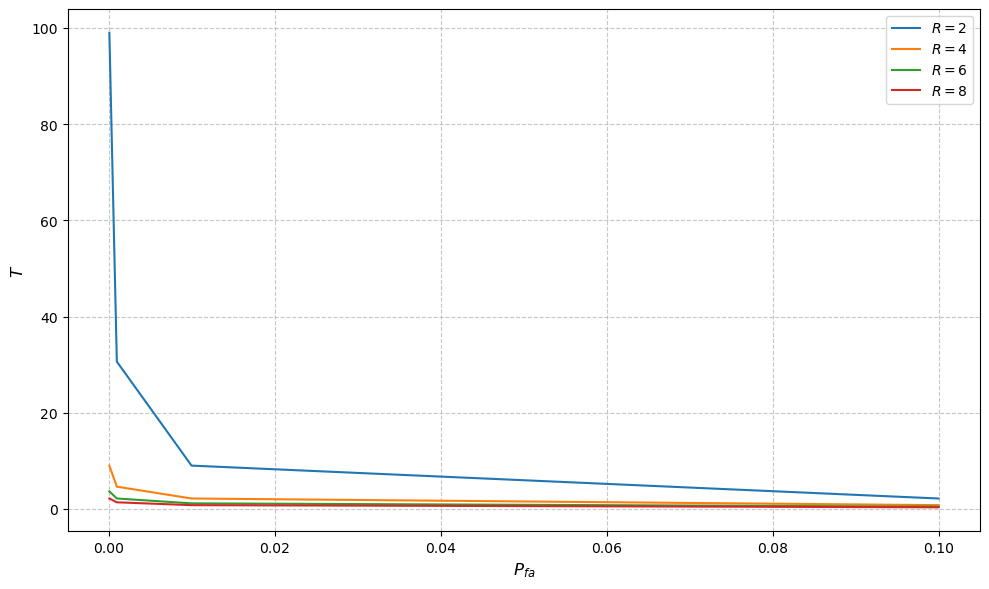

In [48]:
import numpy as np  
import matplotlib.pyplot as plt  

# -----------------------  
# 参数设置  
# -----------------------  
P_fa_values = [1e-4, 1e-3, 1e-2, 1e-1]  # 虚警概率范围: 从 10^-8 到 10^-2  
R_values = np.arange(2, 10, 2)              # 参考单元数范围: 从 2 到 10

# -----------------------  
# 不同虚警概率下门限因子 T 随参考单元数 R 的变化  
# -----------------------  
plt.figure(figsize=(10, 6))  
for P_fa in P_fa_values:  # 固定多个虚警概率  
    T_values = [(P_fa ** (-1 / R) - 1) for R in R_values]  
    plt.plot(R_values, T_values, label=f'$P_{{fa}} = {P_fa:.0e}$')  

# 配置图表  
plt.xlabel('Ref Number $R$', fontsize=12)  
plt.ylabel('$T$', fontsize=12)  
# plt.title('不同虚警概率下门限因子 $T$ 随参考单元数 $R$ 的变化', fontsize=14)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.legend(fontsize=10)  
plt.tight_layout()  
plt.show()  

# -----------------------  
# 不同参考单元数下门限因子 T 随虚警概率 P_fa 的变化  
# -----------------------  
plt.figure(figsize=(10, 6))  
for R in R_values:  # 固定多个参考单元数  
    T_values = [(P_fa ** (-1 / R) - 1) for P_fa in P_fa_values]  
    plt.plot(P_fa_values, T_values, label=f'$R = {R}$')  

# 配置图表  
plt.xlabel('$P_{fa}$', fontsize=12)  
plt.ylabel('$T$', fontsize=12)  
# plt.title('不同参考单元数下门限因子 $T$ 随虚警概率 $P_{fa}$ 的变化', fontsize=14)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.legend(fontsize=10)  
plt.tight_layout()  
plt.show()  

---

### SO-CFAR

在 **SO-CFAR（Smallest of CFAR）** 中，门限因子 $ T $ 需要通过特定的公式迭代计算。SO-CFAR 的虚警概率 $ P_{fa} $ 满足以下关系：

$$
P_{fa} = \sum_{i=0}^{n-1} 2 \binom{n+i-1}{i} (2 + T)^{-(n+i)}
$$

其中：
- $ n $是滑动窗口参考单元的一半个数（总参考单元数 $R = 2n $）；
- $ T $是门限因子（待求解）；

由于这种关系具有一定复杂性，$ T $通常通过数值方法（如迭代或数值求解）计算。

以下是 **SO-CFAR** 的 Python 实现，用以绘制门限因子 $ T $曲线图。